<img src="figuras/cabecera.png" alt="Drawing" style="width: 1100px;"/>

# EJERCICIO 3
# Aprendizaje supervisado: Clasificación.

## *Clasificación binaria de precios de electricidad en el Mercado Diario*

**Objetivo:** Imaginando que estamos a medioados de 2020, predecir en qué horas el precio de la electricidad en el Mercado Diario será elevado, siendo la **clase 0** para valores menores a 40 €, y **clase 1** para valores mayores a 40 €.  Se utilizará el contexto y datos históricos del **2020** de la variable target que queremos clasificar y de otros atributos (features) que pueden ayudar a predecir modelo.


### Antes de empezar:

* En el archivo **EJ3-data-precios.xlsx** se encuentra el conjunto de datos de entrada de este ejemplo (atributos + etiqueta). 
* Datos del 2 de enero 2020 al 26 de junio de 2020.


## **1. Importar librerías y datos**


In [2]:
# Importamos las librerías
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Cargamos el conjunto de datos de entrada
dataset=pd.read_excel('EJ3-data-precios.xlsx')

## **2. Comprender los datos**

Es necesario visualizar y comprender los datos con los que vamos a trabajar, así como conocer sus características. 

1. ¿Cuántos datos hay? ¿Cuántos atributos hay en los datos?  
2. ¿Qué significan?
3. ¿Falta algún dato?
4. ¿Están balanceadas las etiquetas? 
4. Resumen estadístico del conjunto de datos de entrada.

**1. ¿Cuántos datos hay?**   **¿Cuántos atributos hay en los datos?** 

In [3]:
# Filasxcolumnas de los datos
dataset.shape


(4223, 14)

In [4]:
# Observa las primeras 5 filas de los datos
dataset.head()

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior,precio
0,0,2,1,5221.1,1639.0,13290.5,2500.5,2493.8,7093.6,430.0,270,41.88,11.27,menor que 40 euros
1,1,2,1,4928.5,1568.4,12720.1,2411.5,2447.8,7091.6,430.0,243,38.60,11.27,menor que 40 euros
2,2,2,1,4860.3,1566.3,12558.6,2307.5,2446.6,7092.6,417.0,362,36.55,11.27,menor que 40 euros
3,3,2,1,4980.8,1781.5,12837.5,2307.5,2436.7,7092.6,387.0,369,32.32,11.27,menor que 40 euros
4,4,2,1,4984.3,1998.2,13100.9,2374.2,2448.3,7094.6,387.0,413,30.85,11.27,menor que 40 euros


**2. ¿Qué significan?** 
* ***[Hora, Día, Mes]*** Hora, día y mes de cada una de las observaciones. Son valores enteros *int64*.

* ***[Hidraul, Eolica, Ciclocomb, Cogener, Nuclear, Carbon, Biomas]*** se refiere a la energía programada horaria del programa PVP en el mercado diario por tipo de producción del día anterior.  Son valores reales *float*.

* ***[Demanda]*** es la totalidad de energía programada en el mercado diario eléctrico en España el día anterior.  Son valores reales *float*.

* ***[precio-elect-dia-anterior]*** precio de la electricidad el día anterior. Son valores reales *float*.

* ***[MIBGAS-dia-anterior]*** precio del gas natural el día anterior. Son valores reales *float*.

* ***[Clases]*** son las etiquetas de precio que queremos predecir. Son valores enteros *int64*.




In [5]:
# Formato de los datos
dataset.dtypes

hora                           int64
dia                            int64
mes                            int64
hidraul                      float64
eolica                       float64
demanda                      float64
ciclocomb                    float64
cogener                      float64
nuclear                      float64
carbon                       float64
biomas                         int64
precio-elect-dia-anterior    float64
MIBGAS-dia-anterior          float64
precio                        object
dtype: object

**3. ¿Falta algún dato? De ser así, indica cuántos y en que atributo** 



In [6]:
# Comprobar si falta algún dato y en qué atributo
dataset.isna().sum()

hora                         0
dia                          0
mes                          0
hidraul                      0
eolica                       0
demanda                      3
ciclocomb                    0
cogener                      0
nuclear                      0
carbon                       3
biomas                       0
precio-elect-dia-anterior    0
MIBGAS-dia-anterior          0
precio                       0
dtype: int64

**4. ¿Están balanceadas las etiquetas?** 

menor que  40 euros    3507
mayor que  40 euros     716
Name: precio, dtype: int64


<AxesSubplot:ylabel='precio'>

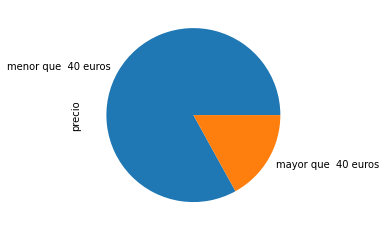

In [7]:
# Comprobar si las etiquetas están desvalanceadas
balance_clases = dataset['precio'].value_counts()
print(balance_clases)

# Gráfico del balance de clases
balance_clases.plot.pie()

### 1. Resampling 

Una técnica ampliamente adoptada para tratar conjuntos de datos muy desequilibrados se denomina remuestreo. Consiste en eliminar muestras de la clase mayoritaria (submuestreo) y/o añadir más ejemplos de la clase minoritaria (sobremuestreo).

<img src="figuras/resampling.png" alt="Drawing" style="width: 800px;"/>

**Oversampling de la clase minoritaria**

El sobremuestreo puede definirse como añadir más copias de la clase minoritaria. El sobremuestreo puede ser una buena opción cuando no se tiene muchos datos con los que trabajar.

Utilizaremos el módulo de remuestreo de Scikit-Learn para replicar aleatoriamente muestras de la clase minoritaria.

In [8]:

df_majority  = dataset[dataset['precio'] == 'menor que  40 euros']
df_minority  = dataset[dataset['precio'] == 'mayor que  40 euros']


In [9]:
df_minority

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior,precio
7,7,2,1,5017.1,1913.8,13248.3,2345.1,2480.7,7094.6,387.0,354,30.00,11.27,mayor que 40 euros
8,8,2,1,5260.7,1704.3,13628.5,2307.5,2473.1,7093.6,387.0,477,30.65,11.27,mayor que 40 euros
9,9,2,1,5330.8,1539.4,14256.6,2307.5,2491.2,7093.6,387.0,450,30.65,11.27,mayor que 40 euros
10,10,2,1,5658.3,1353.4,15053.8,1977.5,2522.9,7094.6,387.0,427,30.27,11.27,mayor que 40 euros
11,11,2,1,5689.7,1137.9,15410.5,1977.5,2542.8,7093.6,387.0,219,30.34,11.27,mayor que 40 euros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,21,24,6,3510.8,4823.3,28716.8,6307.5,3160.6,5810.5,423.0,288,38.69,6.96,mayor que 40 euros
4199,0,26,6,3309.8,3444.1,24964.5,4861.9,3050.6,5068.2,432.0,387,40.75,7.28,mayor que 40 euros
4207,8,26,6,4516.6,1816.4,26802.2,7006.5,3157.7,5070.2,504.5,498,42.09,7.28,mayor que 40 euros
4219,20,26,6,4479.3,3828.2,29025.5,7130.7,3203.2,5063.4,946.0,453,41.23,7.28,mayor que 40 euros


In [10]:
from sklearn.utils import resample

# upsample minority
df_minority_upsampled = resample(df_minority,
                          replace=True, # sample with replacement
                          n_samples=len(df_majority), # match number in minority class
                          random_state=27) # Set random seed for reproducibility

# Combine the upsampled minority class with the majority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])


In [11]:
df_upsampled

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior,precio
0,0,2,1,5221.1,1639.0,13290.5,2500.5,2493.8,7093.6,430.0,270,41.88,11.27,menor que 40 euros
1,1,2,1,4928.5,1568.4,12720.1,2411.5,2447.8,7091.6,430.0,243,38.60,11.27,menor que 40 euros
2,2,2,1,4860.3,1566.3,12558.6,2307.5,2446.6,7092.6,417.0,362,36.55,11.27,menor que 40 euros
3,3,2,1,4980.8,1781.5,12837.5,2307.5,2436.7,7092.6,387.0,369,32.32,11.27,menor que 40 euros
4,4,2,1,4984.3,1998.2,13100.9,2374.2,2448.3,7094.6,387.0,413,30.85,11.27,menor que 40 euros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,9,24,1,6967.4,2849.2,26544.7,9078.4,3533.2,7096.5,1706.8,521,60.98,13.70,mayor que 40 euros
1192,16,20,2,3683.9,2876.0,22905.6,5507.4,3424.1,7086.0,1300.0,205,42.77,11.12,mayor que 40 euros
586,10,26,1,4991.0,2343.4,21026.6,5760.3,3268.5,7098.4,1493.0,390,48.42,11.65,mayor que 40 euros
576,0,26,1,4396.3,3018.6,19235.6,3118.8,3368.7,7098.4,1459.0,383,51.92,11.65,mayor que 40 euros


menor que  40 euros    3507
mayor que  40 euros    3507
Name: precio, dtype: int64


<AxesSubplot:ylabel='precio'>

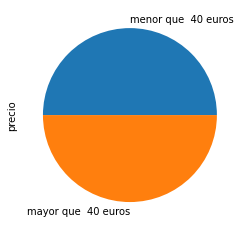

In [12]:
# Comprobar si las etiquetas están desvalanceadas
balance_clases = df_upsampled['precio'].value_counts()
print(balance_clases)

# Gráfico del balance de clases
balance_clases.plot.pie()

**5. Resumen estadístico del conjunto de datos de entrada:** La estadística descriptiva recolecta y analiza el conjunto de datos de entrada con el objetivo de describir las características y comportamientos de este conjunto mediante las siguientes medidas resumen: número total de observaciones (count), media (mean), desviación estándar (std), valor mínimo (min), valor máximo (max) y los valores de los diferentes cuartiles (25%, 50%, 75%).

In [13]:
# Datos estadísticos de cada uno de los atributos
dataset.describe()

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior
count,4223.000000,4223.000000,4223.000000,4223.000000,4223.000000,4220.000000,4223.000000,4223.000000,4223.000000,4220.000000,4223.000000,4223.000000,4223.000000
mean,11.502250,15.411556,3.443287,3090.683495,6142.901373,20223.538578,2337.097135,3059.788942,6019.210466,674.060308,374.144684,28.813694,8.288518
std,6.922282,8.598094,1.674775,1398.795645,3488.275912,3945.242127,1488.503359,282.994453,1212.068728,444.206117,102.061931,10.929161,2.347374
min,0.000000,1.000000,1.000000,856.600000,614.400000,0.000000,460.000000,1825.500000,3410.200000,0.000000,197.000000,1.020000,4.170000
25%,6.000000,8.000000,2.000000,1924.150000,3447.650000,17123.000000,1255.600000,2909.150000,4886.200000,413.000000,287.000000,21.080000,6.040000
50%,12.000000,15.000000,3.000000,2760.400000,5394.900000,20094.500000,1962.600000,3089.300000,6730.500000,530.000000,373.000000,28.410000,8.180000
75%,17.500000,23.000000,5.000000,4126.450000,8229.350000,22871.725000,2893.350000,3238.150000,7089.500000,973.000000,462.000000,36.670000,9.975000
max,23.000000,31.000000,6.000000,7411.900000,18996.300000,35458.900000,9078.400000,3696.800000,7100.500000,2065.000000,551.000000,62.480000,14.480000


## **3. Visualizar los datos**

Una manera visual de entender los datos de entrada. 
1. Histograma
2. Curva de densidad
3. Boxplots
4. Matriz de correlación


**1. Histograma**

Respresentación gráfica de cada uno de los atributos en forma de barras, donde la superficie de la barra es proporcional a la frecuencia de los valores representados.

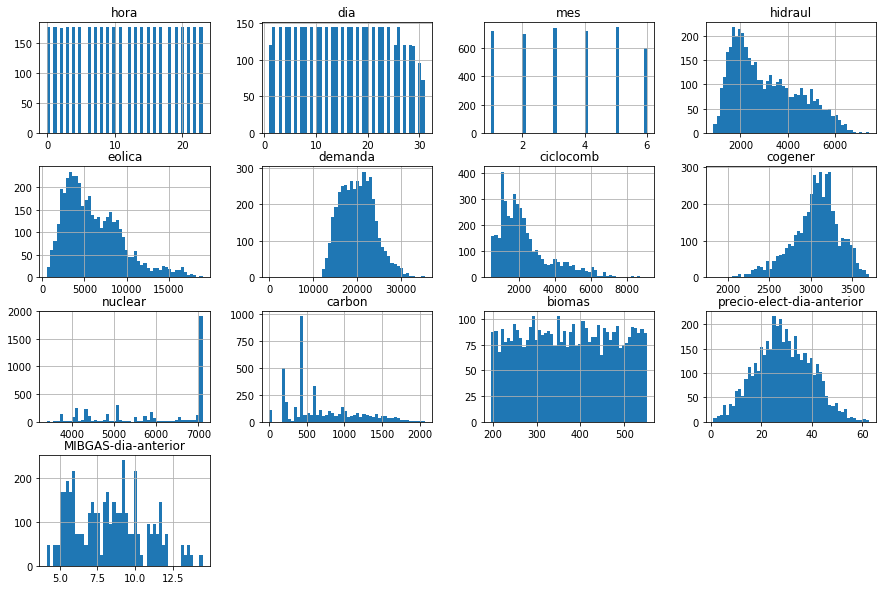

In [14]:
histograma = dataset.hist(xlabelsize=10, ylabelsize=10, bins=50, figsize=(15, 10))

**2. Gráfico de densidades**

Visualiza la distribución de los datos. Es una variable del histograma, pero elimina el ruido, por lo que son mejores para determinar la forma de distribución de un atributo. Lo spicos del gráfico de densidad ayudan a mostrar dónde los valores se concentran más. 

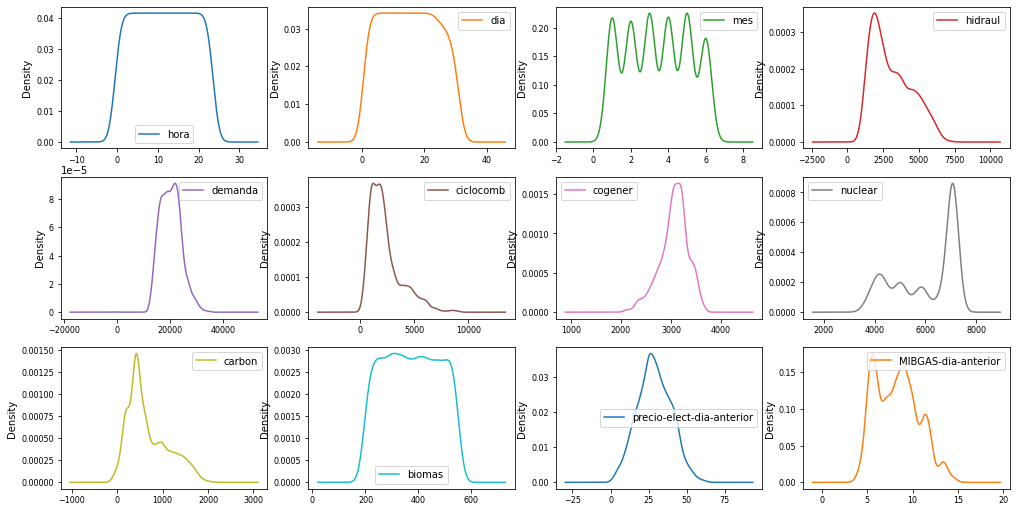

In [15]:
density = dataset.plot(kind='kde', x=4, subplots=True, legend=True, layout=(4, 4), figsize=(17, 12), sharex=False,
                        fontsize=8, stacked=True) 

**3. Boxplots** 

El boxplot (diagrama de caja) nos permite identificar los valores atípicos y comparar distribuciones. Además, se conoce como se distribuyen el 50% de los valores (dentro de la caja).

* **¿Que atributo llama la atención por sus valores atípicos?**. 

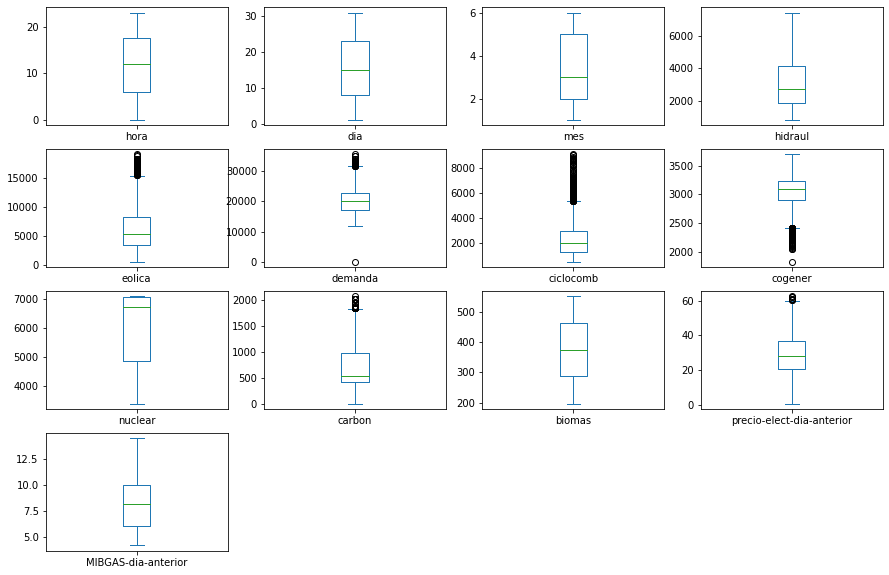

In [16]:
atributos_boxplot = dataset.plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 10), sharex=False,
                                 sharey=False, fontsize=10)

**4. Matriz de correlación** 
Utilizamos el método de Spearman para evaluar la relación monótona entre dos variables contínuas. 

Comparación entre método de [Pearson y Spearman]

[Pearson y Spearman]: https://support.minitab.com/es-mx/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/


* **¿Qué variable no tiene ninguna correlación con ningún atributo?** 

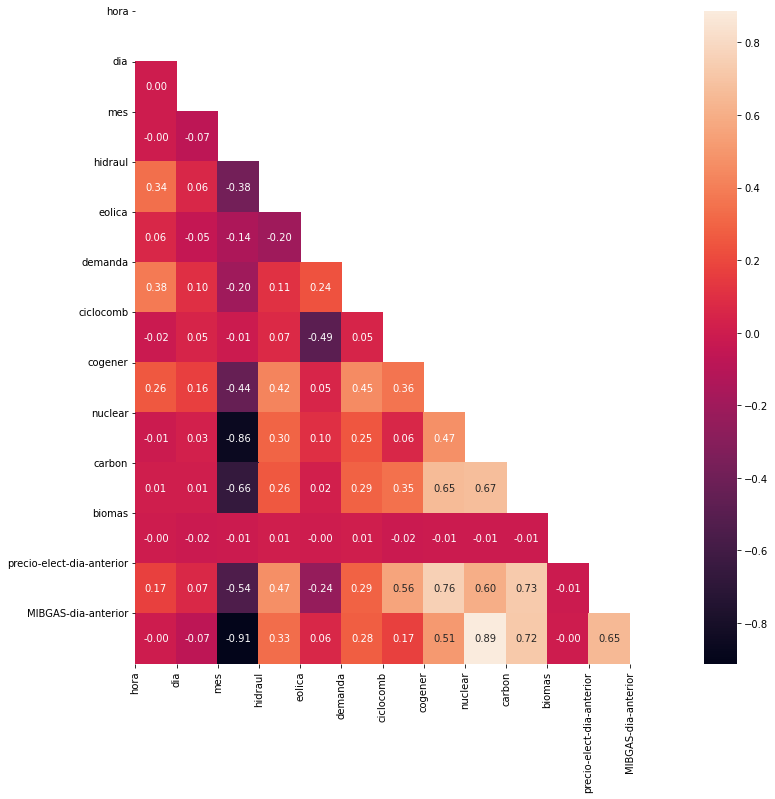

In [17]:
# Otra librería de visualización de datos
import seaborn as sns

# Cálculo de coeficientes de correlación
corr_matrix = dataset.corr(method='spearman') 


# Quitar valores repetidos
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

  
f, ax = plt.subplots(figsize=(12, 12))
#Generar Heat Map,
sns.heatmap(corr_matrix, annot=True, fmt=".2f" , mask=mask,)
    # xticks
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns);
    # yticks
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    # plot
plt.show()

No podemos ver la correlación con el precio, debemos pasarlo a numérico *LabelEncoder*

In [18]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder() 
lab_encoder.fit(dataset['precio'])  
print(lab_encoder.classes_)  # Muestra las clases diferentes que hay

dataset['precio'] = lab_encoder.transform(dataset['precio'])
print(dataset)

['mayor que  40 euros' 'menor que  40 euros']
      hora  dia  mes  hidraul  eolica  demanda  ciclocomb  cogener  nuclear  \
0        0    2    1   5221.1  1639.0  13290.5     2500.5   2493.8   7093.6   
1        1    2    1   4928.5  1568.4  12720.1     2411.5   2447.8   7091.6   
2        2    2    1   4860.3  1566.3  12558.6     2307.5   2446.6   7092.6   
3        3    2    1   4980.8  1781.5  12837.5     2307.5   2436.7   7092.6   
4        4    2    1   4984.3  1998.2  13100.9     2374.2   2448.3   7094.6   
...    ...  ...  ...      ...     ...      ...        ...      ...      ...   
4218    19   26    6   4230.5  3680.1  29267.6     7090.4   3200.0   5061.4   
4219    20   26    6   4479.3  3828.2  29025.5     7130.7   3203.2   5063.4   
4220    21   26    6   3800.5  3712.7  29266.4     6764.1   3217.7   5062.4   
4221    22   26    6   3529.7  3780.1  28711.2     6745.1   3215.0   5064.4   
4222    23   26    6   2650.6  3676.9  26581.4     6650.9   3209.0   5065.4   

     

In [19]:
# replace column values 0: menor que 40; 1: mayor que 40. 

dataset['precio'] = dataset['precio'].map({0:1, 1:0})
dataset.to_excel('dataset.xlsx')


In [20]:
dataset

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior,precio
0,0,2,1,5221.1,1639.0,13290.5,2500.5,2493.8,7093.6,430.0,270,41.88,11.27,0
1,1,2,1,4928.5,1568.4,12720.1,2411.5,2447.8,7091.6,430.0,243,38.60,11.27,0
2,2,2,1,4860.3,1566.3,12558.6,2307.5,2446.6,7092.6,417.0,362,36.55,11.27,0
3,3,2,1,4980.8,1781.5,12837.5,2307.5,2436.7,7092.6,387.0,369,32.32,11.27,0
4,4,2,1,4984.3,1998.2,13100.9,2374.2,2448.3,7094.6,387.0,413,30.85,11.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,19,26,6,4230.5,3680.1,29267.6,7090.4,3200.0,5061.4,946.0,365,40.44,7.28,0
4219,20,26,6,4479.3,3828.2,29025.5,7130.7,3203.2,5063.4,946.0,453,41.23,7.28,1
4220,21,26,6,3800.5,3712.7,29266.4,6764.1,3217.7,5062.4,946.0,362,40.24,7.28,0
4221,22,26,6,3529.7,3780.1,28711.2,6745.1,3215.0,5064.4,946.0,424,40.10,7.28,1


#### Volvemos a mostrar la matriz de correlación con el valor del precio [1 (muy alto), 0 (normal)]


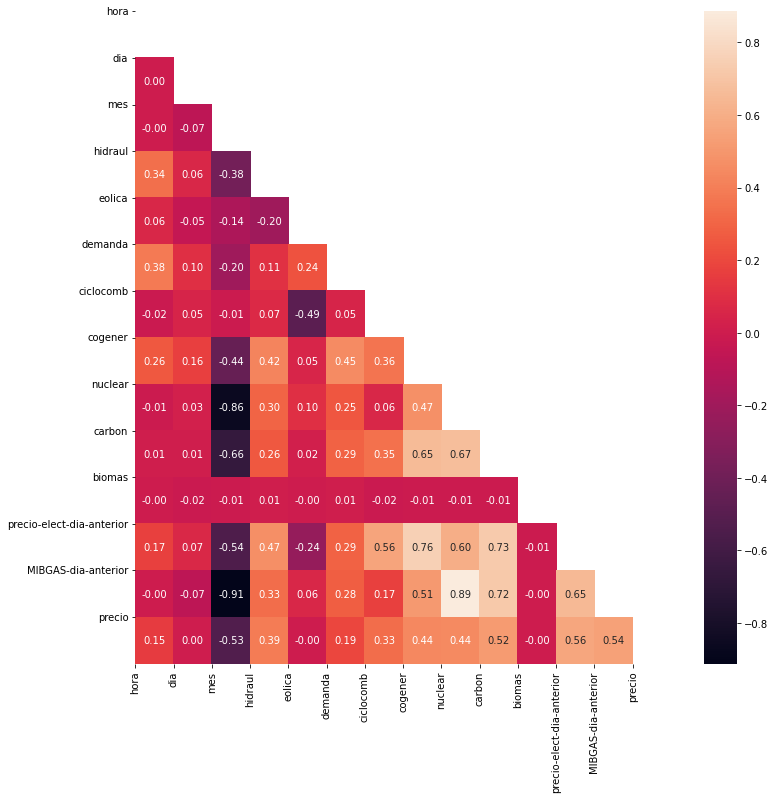

In [21]:
# Cálculo de coeficientes de correlación
corr_matrix = dataset.corr(method='spearman') 


# Quitar valores repetidos
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

  
f, ax = plt.subplots(figsize=(12, 12))
#Generar Heat Map,
sns.heatmap(corr_matrix, annot=True, fmt=".2f" , mask=mask,)
    # xticks
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns);
    # yticks
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    # plot
plt.show()

## *4. Preparar los datos*

1. Missing data
2. Data cleaning (eliminar outliers).
3. LabelEncoding (ya lo hemos hecho)
4. Feature engineering
5. Transformación.

Primero, divido los datos en **atributos**: X (features) y **etiquetas**: y (target)

In [22]:
# Atributos X (features); etiquetas y (target)
X = dataset.drop(['precio'], axis=1) 
y = dataset['precio']
X

,hora,dia,mes,hidraul,eolica,demanda,ciclocomb,cogener,nuclear,carbon,biomas,precio-elect-dia-anterior,MIBGAS-dia-anterior
0,0,2,1,5221.1,1639.0,13290.5,2500.5,2493.8,7093.6,430.0,270,41.88,11.27
1,1,2,1,4928.5,1568.4,12720.1,2411.5,2447.8,7091.6,430.0,243,38.60,11.27
2,2,2,1,4860.3,1566.3,12558.6,2307.5,2446.6,7092.6,417.0,362,36.55,11.27
3,3,2,1,4980.8,1781.5,12837.5,2307.5,2436.7,7092.6,387.0,369,32.32,11.27
4,4,2,1,4984.3,1998.2,13100.9,2374.2,2448.3,7094.6,387.0,413,30.85,11.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4218,19,26,6,4230.5,3680.1,29267.6,7090.4,3200.0,5061.4,946.0,365,40.44,7.28
4219,20,26,6,4479.3,3828.2,29025.5,7130.7,3203.2,5063.4,946.0,453,41.23,7.28
4220,21,26,6,3800.5,3712.7,29266.4,6764.1,3217.7,5062.4,946.0,362,40.24,7.28
4221,22,26,6,3529.7,3780.1,28711.2,6745.1,3215.0,5064.4,946.0,424,40.10,7.28


**Missing data**

Comprobar si exisiten Nan en los datos de entrada. 

- Se utiliza el método [fillna] de Pandas.

- Más información acerca de cómo imputar valores con [Scikit Learn]

[Scikit Learn]: https://scikit-learn.org/stable/modules/impute.html
[fillna]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html





In [23]:
# Comprobar si faltan datos en los atributos
X.isna().sum()

hora                         0
dia                          0
mes                          0
hidraul                      0
eolica                       0
demanda                      3
ciclocomb                    0
cogener                      0
nuclear                      0
carbon                       3
biomas                       0
precio-elect-dia-anterior    0
MIBGAS-dia-anterior          0
dtype: int64

In [24]:
# Relleno los missing values de cada atributo con el valor anterior del atributo. 
X["demanda"].fillna(method='ffill', inplace=True)
X["carbon"].fillna(method='bfill', inplace=True)

In [25]:
# Comprobar si faltan datos en el target
y.isna().sum()

0

In [26]:
# Comprueba que no falta ningún valor
X.isna().sum()

hora                         0
dia                          0
mes                          0
hidraul                      0
eolica                       0
demanda                      0
ciclocomb                    0
cogener                      0
nuclear                      0
carbon                       0
biomas                       0
precio-elect-dia-anterior    0
MIBGAS-dia-anterior          0
dtype: int64

**3. Feature engineering**

Utilizando la matriz de correlación, eliminar los atributos con una correlacion cercana a 0 con la etiqueta **"precio"**. 

* **¿Qué atributo(s) se elimana(n)?** 

In [27]:
# Elimino el atributo
X.drop(['biomas', 'dia', 'eolica', 'mes'], axis='columns', inplace=True)
X

,hora,hidraul,demanda,ciclocomb,cogener,nuclear,carbon,precio-elect-dia-anterior,MIBGAS-dia-anterior
0,0,5221.1,13290.5,2500.5,2493.8,7093.6,430.0,41.88,11.27
1,1,4928.5,12720.1,2411.5,2447.8,7091.6,430.0,38.60,11.27
2,2,4860.3,12558.6,2307.5,2446.6,7092.6,417.0,36.55,11.27
3,3,4980.8,12837.5,2307.5,2436.7,7092.6,387.0,32.32,11.27
4,4,4984.3,13100.9,2374.2,2448.3,7094.6,387.0,30.85,11.27
...,...,...,...,...,...,...,...,...,...
4218,19,4230.5,29267.6,7090.4,3200.0,5061.4,946.0,40.44,7.28
4219,20,4479.3,29025.5,7130.7,3203.2,5063.4,946.0,41.23,7.28
4220,21,3800.5,29266.4,6764.1,3217.7,5062.4,946.0,40.24,7.28
4221,22,3529.7,28711.2,6745.1,3215.0,5064.4,946.0,40.10,7.28


## *5. Dividir los datos*
 

In [28]:
from sklearn.model_selection import train_test_split

test_size = 0.2  # porcentaje de los datos de entrada que utilizaré para validar el modelo

# Divido los datos en datos de entreno, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0,
                                                    shuffle=True)



**Transformación (escalado)**. 

* **Escalar los datos utilizando el método de *MinMaxScaler()* dentro del rango [0,1] o StandardScaler()**

In [29]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Escalar los datos de entreno
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled))
X_train_scaled.columns = X_train.columns
X_train_scaled.head()



,hora,hidraul,demanda,ciclocomb,cogener,nuclear,carbon,precio-elect-dia-anterior,MIBGAS-dia-anterior
0,-1.083134,-1.203290,-0.842221,-0.347663,-0.619581,-0.053122,-1.114059,-1.358455,-0.085598
1,1.077250,1.998926,0.557938,1.682326,1.595980,0.885520,1.995761,1.706970,0.877665
2,-0.939109,-1.207653,-1.286396,-0.117359,0.017248,-0.987973,-0.585163,-0.249881,-1.177870
3,-1.659237,-0.178111,-0.340333,-0.899924,-0.213050,0.888816,-0.274181,-0.269265,0.421835
4,1.077250,-0.644349,-0.443669,0.051406,0.505577,-1.588872,-0.562463,-0.332032,-1.306878


In [30]:
# Mostrar la media y desviación estándar del dataset escalado
print("Mean of standardized dataset:", scaler.mean_)
print("Standard deviation of standardized dataset:", scaler.scale_)

Mean of standardized dataset: [1.15204263e+01 3.07969985e+03 2.01786138e+04 2.31806815e+03
 3.05568697e+03 6.01455583e+03 6.70787626e+02 2.87171433e+01
 8.26905269e+00]
Standard deviation of standardized dataset: [6.94320806e+00 1.39800048e+03 3.92119697e+03 1.45764381e+03
 2.84848901e+02 1.21334886e+03 4.40539967e+02 1.08337324e+01
 2.32542882e+00]


In [31]:

# Escalar los datos de test
X_test_scaled = X_test.copy()
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled))
X_test_scaled.columns = X_test.columns
X_test_scaled.head()


,hora,hidraul,demanda,ciclocomb,cogener,nuclear,carbon,precio-elect-dia-anterior,MIBGAS-dia-anterior
0,-0.074955,-0.999570,-0.390522,0.818260,-1.110368,-1.604778,-0.342279,0.119336,-1.354182
1,-0.651057,-0.654005,-1.526782,-0.356581,-0.831623,-1.595300,-1.114059,-1.081543,-1.736907
2,-0.363006,-0.645422,2.954018,-1.274707,0.492236,0.387806,-0.228782,-0.343108,0.073512
3,-1.659237,-1.145064,-0.860022,-0.209426,0.324779,-0.996956,-0.564733,-0.244343,-1.177870
4,-0.507032,1.499284,0.785649,1.566797,1.442565,0.885520,1.859564,1.457748,0.877665


In [35]:
# Dividimos los datos en entreno (80%) y validación (15%)

val_size = 0.15  # porcentaje de los datos de entrada que utilizaré para validar el modelo

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=val_size, random_state=0,
                                                    shuffle=True)

In [36]:
X_val_scaled

,hora,hidraul,demanda,ciclocomb,cogener,nuclear,carbon,precio-elect-dia-anterior,MIBGAS-dia-anterior
2852,1.077250,1.263734,1.022184,1.615094,1.392363,0.891536,1.643920,1.512208,1.101280
2718,-0.651057,1.209656,-1.612496,-0.129228,-0.523039,-0.696466,-1.114059,-0.747401,-0.829547
2893,-0.939109,-0.530472,-0.606527,-0.891280,-1.203750,-1.860022,-1.522649,-2.161503,-0.859649
1308,0.357122,-0.041202,-0.078908,0.609224,0.364098,0.885107,1.979871,0.995304,0.709954
784,-1.083134,-1.323390,-0.710450,-0.900129,0.117652,0.883047,0.522569,-0.253573,0.404634
...,...,...,...,...,...,...,...,...,...
2733,-0.939109,-0.738269,-1.037926,-0.492485,0.756587,0.884695,0.991085,-0.066195,0.877665
971,-0.795083,-1.367310,-1.005615,0.201100,-2.366121,-0.212269,-0.176573,-0.807399,-0.094199
2998,-0.939109,-0.813304,0.194631,-0.786453,-0.039273,0.878267,0.277415,-0.583099,0.783059
3292,1.077250,1.777467,2.609939,-1.096337,0.180141,0.880492,-0.585163,0.345482,-0.313513


In [37]:
print('Tamañano de los datos de ENTRENO:', X_train_scaled.shape)
print('Tamañano de los datos de TEST:', X_test_scaled.shape)
print('Tamañano de los datos de VALIDACIÓN (cálculo de hiperparámetros):', X_val_scaled.shape)

Tamañano de los datos de ENTRENO: (1836, 9)
Tamañano de los datos de TEST: (845, 9)
Tamañano de los datos de VALIDACIÓN (cálculo de hiperparámetros): (325, 9)


## *6. Construcción y evaluación de modelos*

* Seleccionamos **[balanced_accuracy]** como métrica de evaluación. 
* Métricas de evaluación disponibles en [Scikit-Learn].


[Scikit-Learn]: https://scikit-learn.org/stable/modules/model_evaluation.html

[balanced_accuracy]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

* Recordar utilizar siempre el mismo random_state para poder comparar resultados. 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

num_folds = 15
error_metrics = {'balanced_accuracy', 'f1_weighted'}
models = { ('LR', LogisticRegression(solver='saga')),
          ('KNN', KNeighborsClassifier()),
           ('RF', RandomForestClassifier()), 
           ('XGB', xgb.XGBClassifier())
         }

results = [] # guarda los resultados de las métricas de evaluación
names = []  # Nombre de cada algoritmo
msg = []  # imprime el resumen del método de cross-validation


* **¿Cuál obtiene mejores resultados?** 
* **¿Qué balanced_accuracy obtiene?** 

Métrica de evaluación:  f1_weighted
Modelo  KNN
Modelo  LR
Modelo  XGB
[10:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

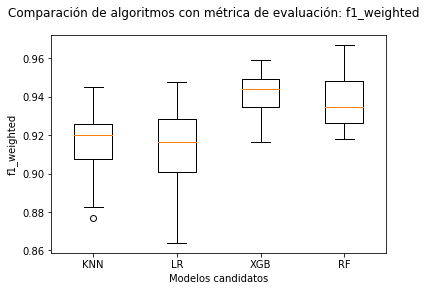

Métrica de evaluación:  balanced_accuracy
Modelo  KNN
Modelo  LR
Modelo  XGB
[10:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old beh

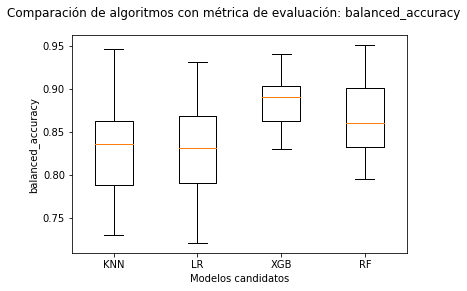

In [39]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedKFold

ite=0

# Entreno con validación cruzada
for scoring in error_metrics:
    print('Métrica de evaluación: ', scoring)
    for name, model in models:
        print('Modelo ', name)
        cross_validation = StratifiedKFold(n_splits=num_folds, random_state=0, shuffle=True)
        cv_results = cross_val_score(model, X_train_scaled, y_train, cv=cross_validation, scoring=scoring)
        results.append(cv_results)
        if ite == 0:
            names.append(name)
        resume = (name, cv_results.mean(), cv_results.std())
        msg.append(resume)
    print(msg)

    # Comparar resultados entre algoritmos
    fig = plt.figure()
    fig.suptitle('Comparación de algoritmos con métrica de evaluación: %s' %scoring)
    ax = fig.add_subplot(111)
    ax.set_xlabel('Modelos candidatos')
    ax.set_ylabel('%s' %scoring)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    results = []
    
    ite += 1

## *7. Ajustar hiperparámetros*

Pasos para realizar el hiperajuste de los parámetros:
[XGBClassifier] parámeteros

* Métrica para optimizar: *balanced_accuracy*
* Definir los rangos de los parámetros de búsqueda: *params*
* Entrenar con los datos de validación: *X_val*

[XGBClassifier]:https://xgboost.readthedocs.io/en/latest/parameter.html

In [41]:

from sklearn.model_selection import StratifiedKFold

# XGBOOST
modelo = xgb.XGBClassifier()
params = {
     'booster': ['gbtree', 'dart'], #default=gbtree
     'eta': [0.1, 0.3], #default=0.3
     # 'max_depth': [3, 6, 8],  #default=6
     #'predictor': ['auto', 'gpu_predictor'] # default auto
 }
scoring='balanced_accuracy'
cross_validation = StratifiedKFold(n_splits=10)
my_cv = cross_validation.split(X_val_scaled, y_val)
gsearch = GridSearchCV(estimator=modelo, param_grid=params, scoring=scoring, cv=my_cv, verbose=2)
gsearch.fit(X_val_scaled, y_val)

print("Mejor resultado: %f utilizando los siguientes hiperparámetros %s" % (gsearch.best_score_, gsearch.best_params_))
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']
params = gsearch.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[10:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ............................booster=gbtree, eta=0.1; total time=   0.0s
[10:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ............................booster=gbtree, eta=0.1; total time=   0.0s
[10:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metri

[CV] END ..............................booster=dart, eta=0.1; total time=   0.1s
[10:18:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............................booster=dart, eta=0.1; total time=   0.1s
[10:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............................booster=dart, eta=0.1; total time=   0.1s
[10:18:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the defa

## *8. Evaluación final del modelo*



Métricas de evaluación:
  * 1. Matriz de confusión
  * 2. Coeficiente de Matthews (MCC)

    
**Entrena el modelo con los hiperparámetros óptimos encontrados en el apartado anterior y realiza las predicciones.** 

In [42]:

modelo_xgb = xgb.XGBClassifier(booster='gbtree', eta=0.3)
modelo_xgb.fit(X_train_scaled,y_train)  # Se entrena al modelo RF
y_predict = modelo_xgb.predict(X_test_scaled)  # Se calculan las predicciones


[10:23:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**1. Matriz de confusión**

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_predict)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       693
           1       0.85      0.86      0.85       152

    accuracy                           0.95       845
   macro avg       0.91      0.91      0.91       845
weighted avg       0.95      0.95      0.95       845



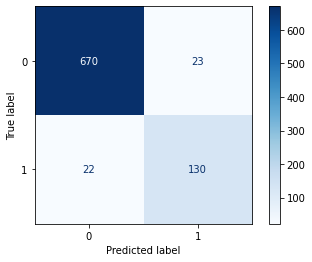

In [44]:
# Gráfico no normalizado de la martiz de confusión

disp = plot_confusion_matrix(modelo_xgb, X_test_scaled, y_test,
                                 cmap=plt.cm.Blues, values_format = '')

**2. Coeficiente de Matthews (MCC)**

El MCC utiliza coeficientes de correlación entre -1 y +1. 
* Coeficiente +1 representa una predicción perfecta
* Coeficiente 0 representa una predicción media aleatoria
* Coeficiente -1 representa una predicción inversa. 

In [45]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_predict)

0.8199750299749626

### Probamos ahora con Random Forest

**¿Qué atributos tienen más peso en el modelo?** 

Para el caso del Random Forest, el atributo más importante para predecir los precios es la generación de carbón, seguido de la generación hidráulica y del mes del año. En la matriz de correlación, el atributo carbón era el que tenía más correlación con la variable clase. 

In [46]:
# modelo_final = RandomForestClassifier(max_features='sqrt', min_samples_split=5,  n_estimators=400, class_weight={0:1,1:5})
modelo_rf = RandomForestClassifier()
modelo_rf.fit(X_train_scaled, y_train)  # Se entrena al modelo RF
y_predict = modelo_rf.predict(X_test_scaled)

In [47]:
# Imprimir la importancia de cada atributo (Solo si Random forest es seleccionado)
importancia_atributos = modelo_rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importancia_atributos)[::-1]
std = np.std([tree.feature_importances_ for tree in modelo_rf.estimators_], axis=0)

# Print the feature ranking
print("Ranking de importancia de atributos:")
for f in range(X_train_scaled.shape[1]):
    print("%d. Atributo %d (%f)" % (f + 1, indices[f], importancia_atributos[indices[f]]))


Ranking de importancia de atributos:
1. Atributo 7 (0.262946)
2. Atributo 8 (0.168638)
3. Atributo 6 (0.143406)
4. Atributo 4 (0.111238)
5. Atributo 1 (0.088649)
6. Atributo 5 (0.061319)
7. Atributo 3 (0.060949)
8. Atributo 2 (0.055771)
9. Atributo 0 (0.047085)


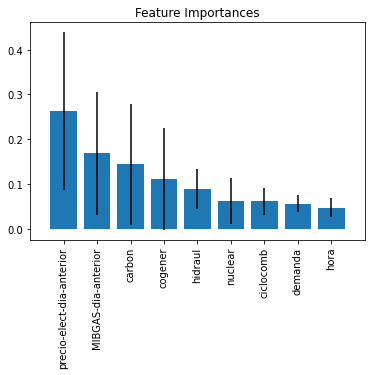

In [48]:


# Grafica la importancia de los atributos
feature_names = X_train_scaled.columns  # creo una lista con el nombre de las features
features = [feature_names[i] for i in indices]  
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_test_scaled.shape[1]), importancia_atributos[indices], yerr=std[indices], align="center")
plt.xticks(range(X_test_scaled.shape[1]), features, rotation=90)
plt.xlim([-1, X_test_scaled.shape[1]])
plt.show()


### Matriz de confusión

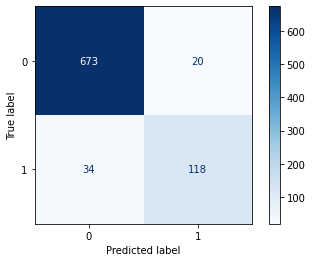

In [49]:
# Gráfico no normalizado de la martiz de confusión

disp = plot_confusion_matrix(modelo_rf, X_test_scaled, y_test,
                                 cmap=plt.cm.Blues, values_format = '')

### Coficiente de Mathew

In [50]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_predict)

0.776648762366644